# Proyecto Patrones - Mi Bici

Integrantes:



*   Luis Ramón Guajardo
*   Jafet Castañeda



# Importación de librerias

In [ ]:
#Generales
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from google.colab import files
import io
import pandas as pd
import seaborn as sn

#Utilities
import geopy.distance

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Prediccion
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Agrupamiento
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE #Importaremos la funcion TSNE de scikit learn

# Carga de datos

## Datos generales

In [ ]:
uploaded = files.upload()

Saving datos_abiertos_2023_05_week.csv to datos_abiertos_2023_05_week.csv


In [ ]:
generalData = pd.read_csv('datos_abiertos_2023_05_week.csv', encoding = 'latin1')

In [ ]:
generalData.head()

,Viaje_Id,Usuario_Id,Genero,Ano_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,Edad,Duracion_de_viaje,Dia,Hora_del_viaje
0,28467098,70123,M,1967.0,01/05/2023 00:00,01/05/2023 00:22,64,141,56,22.266667,lunes,0
1,28467099,2237235,M,1980.0,01/05/2023 00:00,01/05/2023 00:04,36,172,43,4.050000,lunes,0
2,28467100,2051727,F,2002.0,01/05/2023 00:01,01/05/2023 00:10,96,296,21,9.266667,lunes,0
3,28467101,2246225,M,1969.0,01/05/2023 00:01,01/05/2023 00:04,33,255,54,3.116667,lunes,0
4,28467102,324247,M,1975.0,01/05/2023 00:01,01/05/2023 00:13,226,231,48,11.866667,lunes,0


## Coordenadas de zonas

In [ ]:
uploaded = files.upload()

Saving coordenadas_zonas.csv to coordenadas_zonas.csv


In [ ]:
zoneCoords = pd.read_csv('coordenadas_zonas.csv', index_col = 0)

In [ ]:
zoneCoords.head()

,latitude,longitude
id,,
2,20.666378,-103.348820
3,20.667228,-103.366000
4,20.667690,-103.368252
5,20.691750,-103.362550
6,20.681151,-103.338863


## Nomenclatura de zonas

In [ ]:
uploaded = files.upload()

Saving zonas.csv to zonas.csv


In [ ]:
zoneNames = pd.read_csv('zonas.csv', encoding = 'latin1', index_col = 0)

In [ ]:
zoneNames.head()

,location
id,
2,POLÍGONO CENTRAL
3,POLÍGONO CENTRAL
4,POLÍGONO CENTRAL
5,POLÍGONO CENTRAL
6,POLÍGONO CENTRAL


# Construcción de los datos

## Omisión de datos nulos

In [ ]:
generalData.isnull().values.any()
generalData = generalData.dropna(axis=0)

## Muestra de datos

In [ ]:
sampleData = generalData.sample(n=600)

In [ ]:
sampleData.head()

,Viaje_Id,Usuario_Id,Genero,Ano_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,Edad,Duracion_de_viaje,Dia,Hora_del_viaje
254072,28768194,1462560,M,1987.0,22/05/2023 18:52,22/05/2023 18:59,11,35,36,6.916667,lunes,18
306499,28830495,574131,M,1995.0,26/05/2023 19:53,26/05/2023 20:04,260,272,28,11.383333,viernes,19
10486,28479887,2110356,M,1999.0,02/05/2023 11:23,02/05/2023 11:35,106,293,24,12.333333,martes,11
212687,28720484,1663016,F,1970.0,18/05/2023 19:40,18/05/2023 19:49,4,51,53,8.866667,jueves,19
244487,28757022,146677,M,1997.0,21/05/2023 21:42,21/05/2023 21:50,117,286,26,7.533333,domingo,21


In [ ]:
sampleData['Edad'] = sampleData['Edad'].astype(int)

In [ ]:
sampleData.dtypes

Viaje_Id               int64
Usuario_Id             int64
Genero                object
Ano_nacimiento       float64
Inicio_del_viaje      object
Fin_del_viaje         object
Origen_Id              int64
Destino_Id             int64
Edad                   int64
Duracion_de_viaje    float64
Dia                   object
Hora_del_viaje         int64
dtype: object

In [ ]:
gendertext = sampleData['Genero'].tolist()
origenID = sampleData['Origen_Id'].tolist()
destinoID = sampleData['Destino_Id'].tolist()
hour = sampleData['Hora_del_viaje'].tolist()
edad = sampleData['Edad'].tolist()
daytext = sampleData['Dia'].tolist()
duracion = sampleData['Duracion_de_viaje'].tolist()

## Calculo de otras variables de interes

### Genero (0-1)

In [ ]:
gender = []

for i in range(len(gendertext)):
  if gendertext[i] == 'M':
    gender.append(0)
  else:
    gender.append(1)

### Distancias

In [ ]:
distance = []

for i in range(len(origenID)):
  distance.append(geopy.distance.geodesic((zoneCoords.loc[origenID[i]].at['latitude'], zoneCoords.loc[origenID[i]].at['longitude']), (zoneCoords.loc[destinoID[i]].at['latitude'], zoneCoords.loc[destinoID[i]].at['longitude'])).km*1000)


### Dia (1-7)

In [ ]:
day = []

for i in range(len(daytext)):
  if daytext[i] == "lunes":
    day.append(1)
  elif daytext[i] == "martes":
    day.append(2)
  elif daytext[i] == "miércoles":
    day.append(3)
  elif daytext[i] == "jueves":
    day.append(4)
  elif daytext[i] == "viernes":
    day.append(5)
  elif daytext[i] == "sábado":
    day.append(6)
  else:
    day.append(7)

### Intervalo de duracion

In [ ]:
duracionInterval = []

for i in range(len(duracion)):
  if duracion[i] >= 0 and duracion[i] < 5:
    duracionInterval.append(1)
  elif duracion[i] >= 5 and duracion[i] < 10:
    duracionInterval.append(2)
  elif duracion[i] >= 10 and duracion[i] < 15:
    duracionInterval.append(3)
  elif duracion[i] >= 15 and duracion[i] < 20:
    duracionInterval.append(4)
  elif duracion[i] >= 20 and duracion[i] < 25:
    duracionInterval.append(5)
  elif duracion[i] >= 25 and duracion[i] < 30:
    duracionInterval.append(6)
  elif duracion[i] >= 30 and duracion[i] < 35:
    duracionInterval.append(7)
  else:
    duracionInterval.append(8)

### Zonas de origen y de destino

In [ ]:
zonaOrigen = []
zonaDestino = []

for i in range(len(origenID)):
  if zoneNames.loc[origenID[i]].at['location'] == 'POLÍGONO CENTRAL':
    zonaOrigen.append(1)
  elif zoneNames.loc[origenID[i]].at['location'] == 'ZAPOPAN CENTRO':
    zonaOrigen.append(2)
  else:
    zonaOrigen.append(3)

for i in range(len(destinoID)):
  if zoneNames.loc[destinoID[i]].at['location'] == 'POLÍGONO CENTRAL':
    zonaDestino.append(1)
  elif zoneNames.loc[destinoID[i]].at['location'] == 'ZAPOPAN CENTRO':
    zonaDestino.append(2)
  else:
    zonaDestino.append(3)

## Datos con las variables de interes

In [ ]:
totalData = pd.DataFrame(edad, columns = ['Edad'])
totalData['Genero'] = gender
totalData['Origen ID'] = origenID
totalData['Destino ID'] = destinoID
totalData['Dia'] = day
totalData['Hora'] = hour
totalData['Duracion'] = duracion
totalData['Distancia'] = distance
totalData['Intervalo de duracion'] = duracionInterval
totalData['Zona de origen'] = zonaOrigen
totalData['Zona de destino'] = zonaDestino

totalData.head()

,Edad,Genero,Origen ID,Destino ID,Dia,Hora,Duracion,Distancia,Intervalo de duracion,Zona de origen,Zona de destino
0,36,0,11,35,1,18,6.916667,791.957123,2,1,1
1,28,0,260,272,5,19,11.383333,1802.525253,3,1,1
2,24,0,106,293,2,11,12.333333,1997.349364,3,2,2
3,53,1,4,51,4,19,8.866667,1430.854395,2,1,1
4,26,0,117,286,7,21,7.533333,1316.957751,2,2,2


**Importante**: Las variables de
*   Genero
*   ID de origen y destino
*   Zonas de origen y destino
*   Intervalo de duracion

Son categóricas (sirven mas como variables de respuesta para una prediccion) y **se debe evitar considerarlas a la hora de visualizar por PCA o usarlas como predictores (a menos que se usen árboles)**, ya que solo añadiran ruido a los datos.



## Matriz de Correlación y otras relaciones entre variables

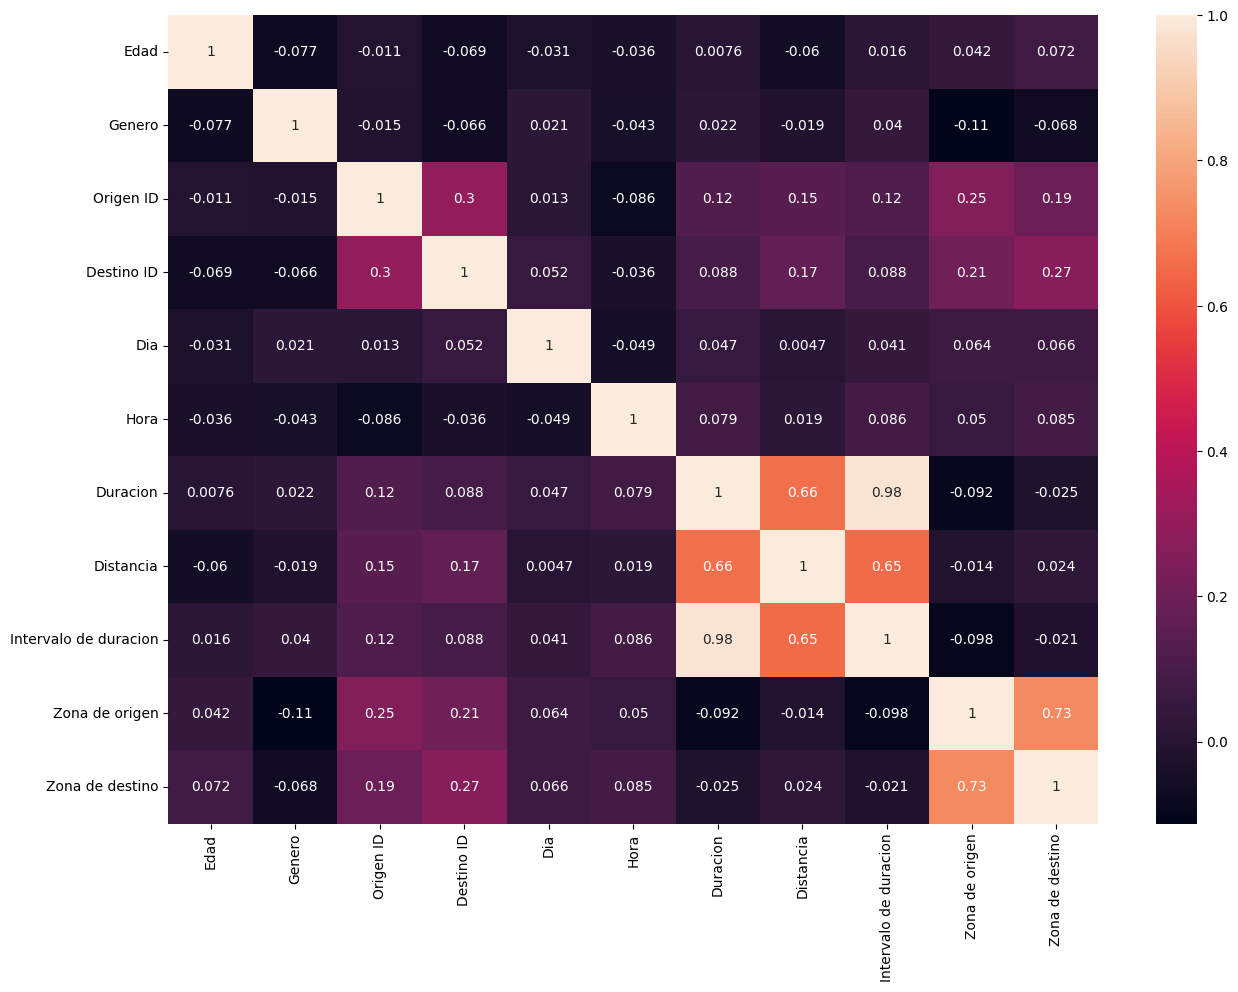

In [ ]:
corr_matrix = totalData.corr()
plt.figure(figsize=(15, 10.5))
sn.heatmap(corr_matrix, annot=True)
plt.show()

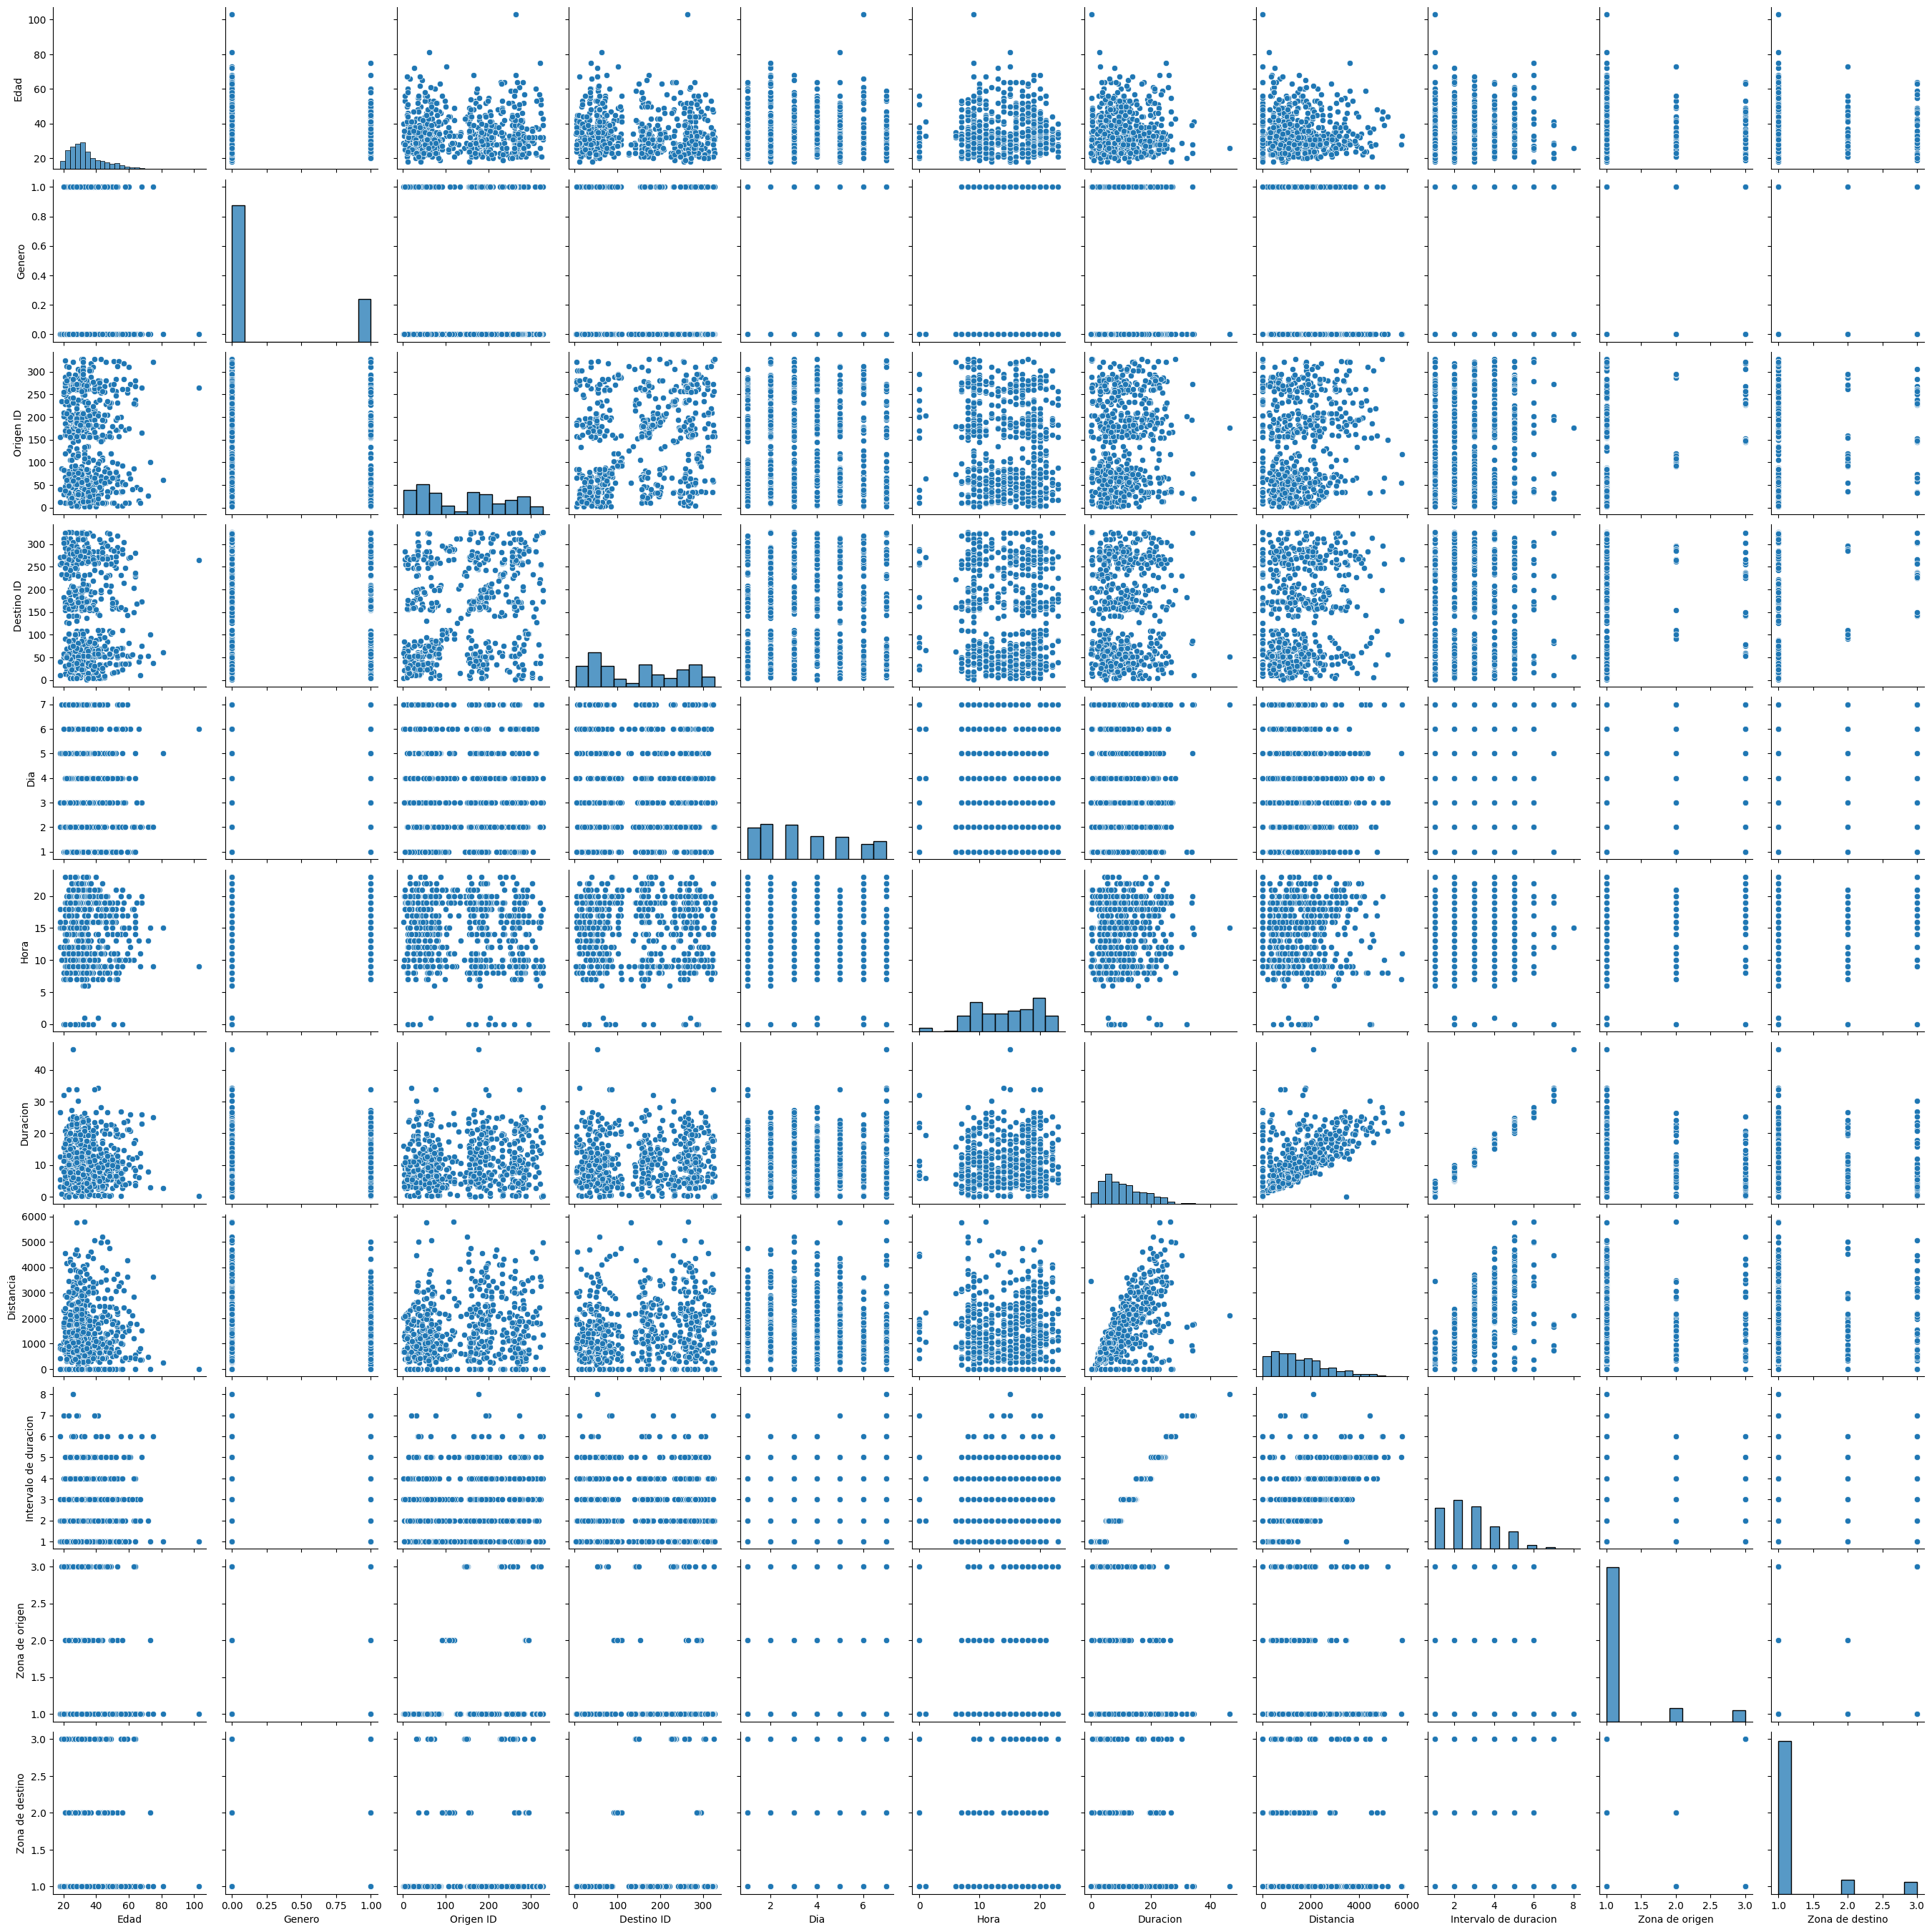

In [ ]:
sn.pairplot(totalData, diag_kind = 'hist')

### Histogramas

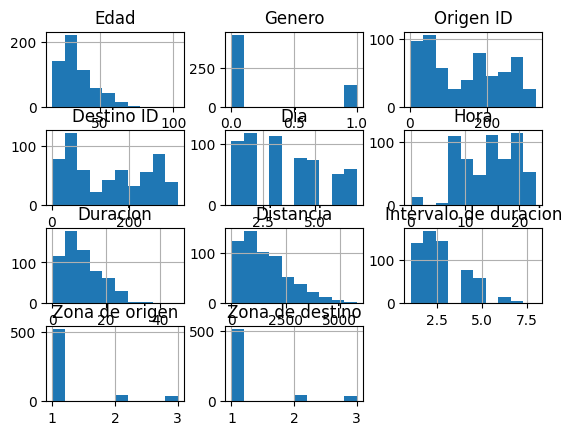

In [ ]:
hist = totalData.hist()

<Axes: xlabel='Edad', ylabel='Duracion'>

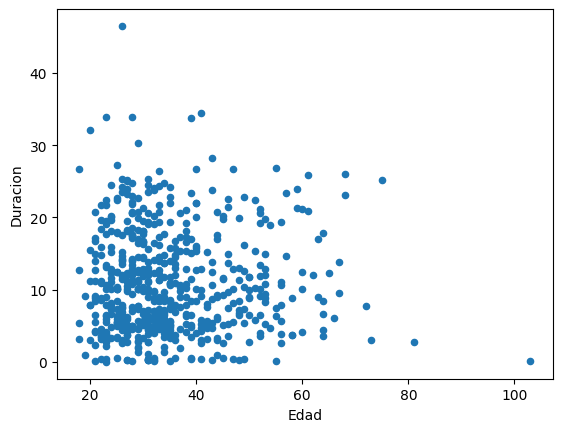

In [ ]:
totalData.plot(x='Edad', y = 'Duracion', kind = 'scatter')

<Axes: xlabel='Hora', ylabel='Duracion'>

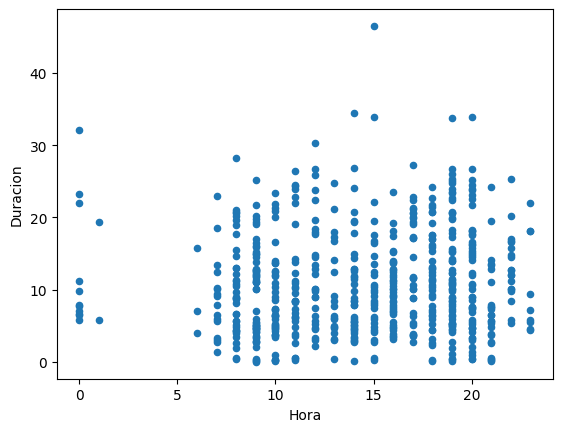

In [ ]:
totalData.plot(x='Hora', y = 'Duracion', kind = 'scatter')

<Axes: xlabel='Distancia', ylabel='Duracion'>

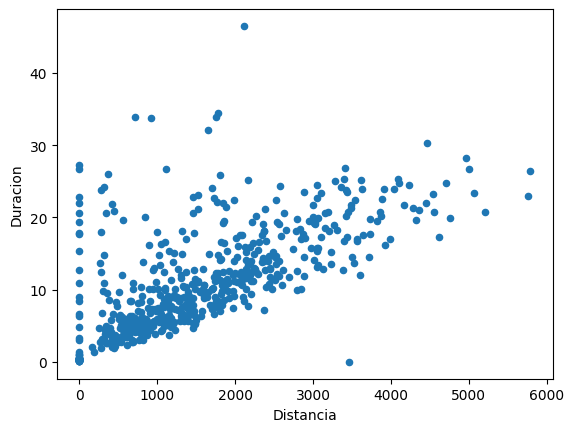

In [ ]:
totalData.plot(x='Distancia', y = 'Duracion', kind = 'scatter')

<Axes: xlabel='Zona de destino', ylabel='Duracion'>

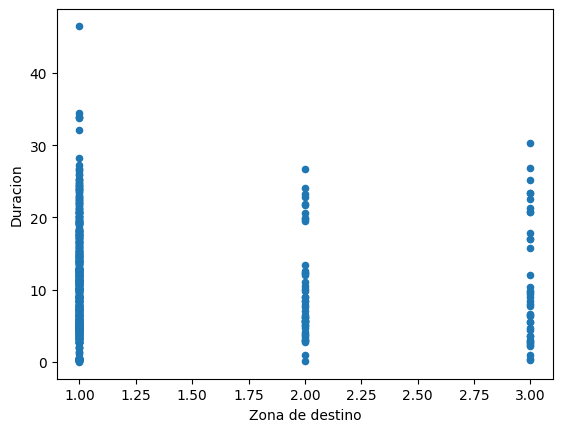

In [ ]:
totalData.plot(x='Zona de destino', y = 'Duracion', kind = 'scatter')

<Axes: xlabel='Genero', ylabel='Duracion'>

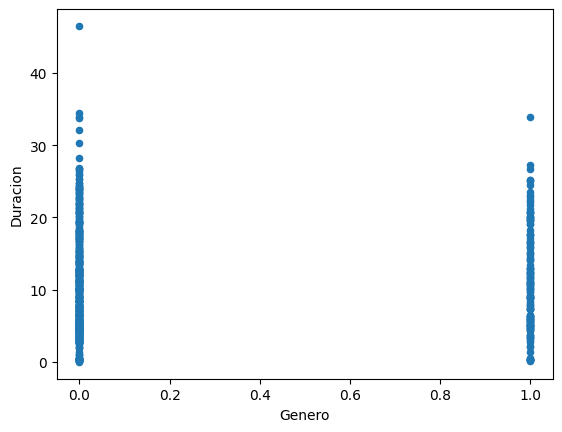

In [ ]:
totalData.plot(x='Genero', y = 'Duracion', kind = 'scatter')

<Axes: xlabel='Hora', ylabel='Genero'>

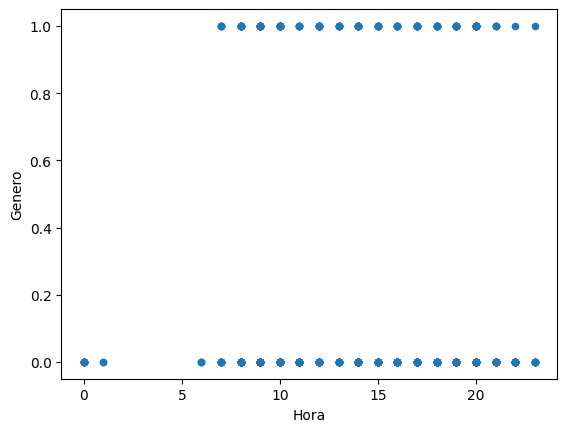

In [ ]:
totalData.plot(x='Hora', y = 'Genero', kind = 'scatter')

<Axes: xlabel='Edad', ylabel='Distancia'>

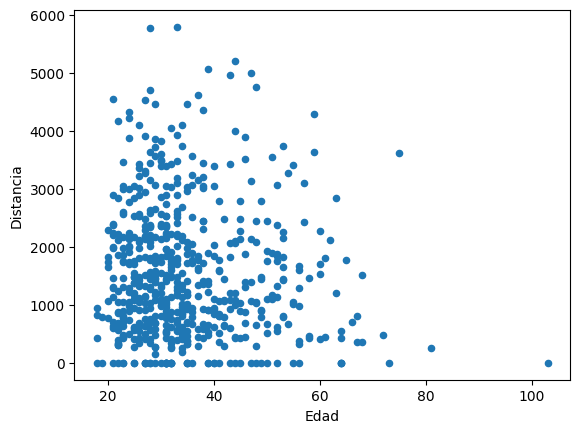

In [ ]:
totalData.plot(x='Edad', y = 'Distancia', kind = 'scatter')

<Axes: xlabel='Origen ID', ylabel='Distancia'>

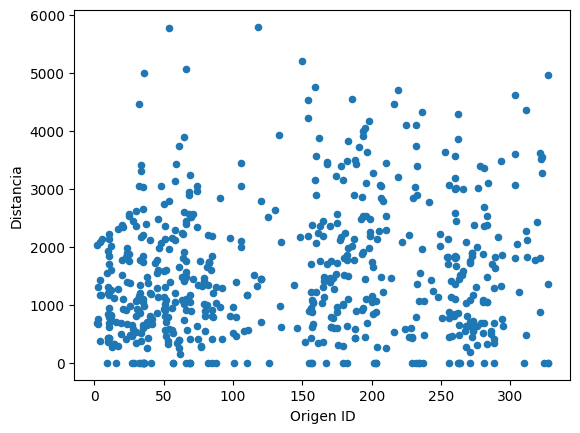

In [ ]:
totalData.plot(x='Origen ID', y = 'Distancia', kind = 'scatter')

# Variable de interés: Duración

## Visualizacion

### Creamos dataframe con variables útiles para este caso

In [ ]:
datavis1 = totalData
datavis1 = datavis1.drop(['Duracion'], axis=1)
datavis1 = datavis1.drop(['Intervalo de duracion'], axis=1)
datavis1 = datavis1.drop(['Zona de origen'], axis=1)
datavis1 = datavis1.drop(['Zona de destino'], axis=1)
datavis1 = datavis1.drop(['Origen ID'], axis=1)
datavis1 = datavis1.drop(['Destino ID'], axis=1)
datavis1 = datavis1.drop(['Genero'], axis=1)

datavis1.head()

,Edad,Dia,Hora,Distancia
0,36,1,18,791.957123
1,28,5,19,1802.525253
2,24,2,11,1997.349364
3,53,4,19,1430.854395
4,26,7,21,1316.957751


In [ ]:
sDatavis1 = StandardScaler().fit_transform(datavis1)

In [ ]:
pca = PCA() #Creamos el objeto PCA
pca.fit(sDatavis1) #Con esta funcion calculamos los loading scores y la variacion asociada a cada CP

pca_data = pca.transform(sDatavis1) #Coordenadas de las proyecciones de los datos respecto a los Principal Components

### Porcentaje de varianza explicada

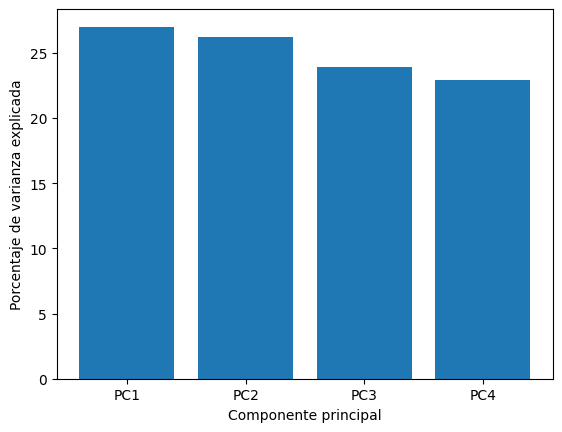

In [ ]:
#Calculamos el porcentaje de varianza asociado a cada componente (lo redondeamos)
var_explained = np.round(pca.explained_variance_ratio_*100, decimals = 1)

#Creamos las etiquetas de la grafica, una para cada CP (PC en ingles)
labels = ['PC' + str(x) for x in range(1, len(var_explained) + 1)] #PC1, PC2, PC3, ...

#Creamos una barplot con estos datos
plt.bar(x = range(1, len(var_explained) + 1), height = var_explained, tick_label = labels)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.show()

In [ ]:
pca_dataframe = pd.DataFrame(pca_data, columns = labels)
pca_dataframe['Duracion'] = duracion
pca_dataframe['Genero'] = gender
pca_dataframe.head()

,PC1,PC2,PC3,PC4,Duracion,Genero
0,0.202875,-1.525000,-0.292802,-0.450517,6.916667,0
1,-0.963217,0.233446,-0.777238,0.552548,11.383333,0
2,-0.560426,0.058251,0.591528,-1.211937,12.333333,0
3,0.708874,-0.692011,-0.090978,1.555288,8.866667,1
4,-1.028362,0.792581,-1.730789,1.043609,7.533333,0


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis1.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Duracion", title = "PCA - Duracion ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis1.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Genero", title = "PCA - Genero ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

### ¿La distancia está haciendo todo el trabajo al tener mucho que ver con la duración?

In [ ]:
datavis1 = datavis1.drop(['Distancia'], axis=1)

datavis1.head()

,Edad,Dia,Hora
0,36,1,18
1,28,5,19
2,24,2,11
3,53,4,19
4,26,7,21


In [ ]:
sDatavis1 = StandardScaler().fit_transform(datavis1)

In [ ]:
pca = PCA() #Creamos el objeto PCA
pca.fit(sDatavis1) #Con esta funcion calculamos los loading scores y la variacion asociada a cada CP

pca_data = pca.transform(sDatavis1) #Coordenadas de las proyecciones de los datos respecto a los Principal Components

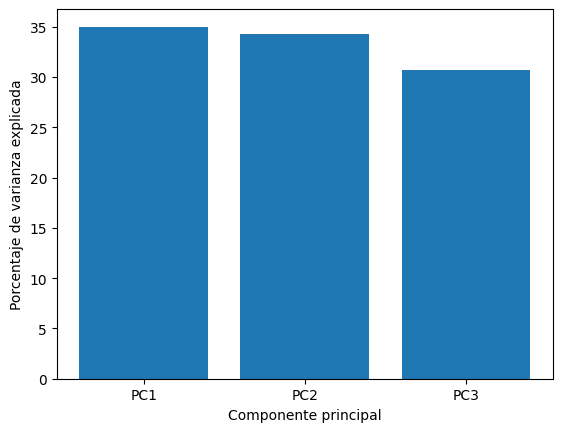

In [ ]:
#Calculamos el porcentaje de varianza asociado a cada componente (lo redondeamos)
var_explained = np.round(pca.explained_variance_ratio_*100, decimals = 1)

#Creamos las etiquetas de la grafica, una para cada CP (PC en ingles)
labels = ['PC' + str(x) for x in range(1, len(var_explained) + 1)] #PC1, PC2, PC3, ...

#Creamos una barplot con estos datos
plt.bar(x = range(1, len(var_explained) + 1), height = var_explained, tick_label = labels)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.show()

In [ ]:
pca_dataframe = pd.DataFrame(pca_data, columns = labels)
pca_dataframe['Duracion'] = duracion
pca_dataframe['Genero'] = gender
pca_dataframe.head()

,PC1,PC2,PC3,Duracion,Genero
0,-1.378117,0.491353,0.282183,6.916667,0
1,-0.241345,-1.124637,-0.719042,11.383333,0
2,-0.125216,-0.260450,1.376268,12.333333,0
3,-0.308498,0.957662,-1.544826,8.866667,1
4,0.125856,-1.865744,-1.494670,7.533333,0


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis1.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Duracion", title = "PCA - Duracion ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


## Agrupamiento

In [ ]:
data_cluster = totalData
data_cluster = data_cluster.drop(['Duracion'], axis=1)
data_cluster = data_cluster.drop(['Intervalo de duracion'], axis=1)
data_cluster = data_cluster.drop(['Origen ID'], axis=1)
data_cluster = data_cluster.drop(['Destino ID'], axis=1)
data_cluster.head()

,Edad,Genero,Dia,Hora,Distancia,Zona de origen,Zona de destino
0,36,0,1,18,791.957123,1,1
1,28,0,5,19,1802.525253,1,1
2,24,0,2,11,1997.349364,2,2
3,53,1,4,19,1430.854395,1,1
4,26,0,7,21,1316.957751,2,2


Dendograma

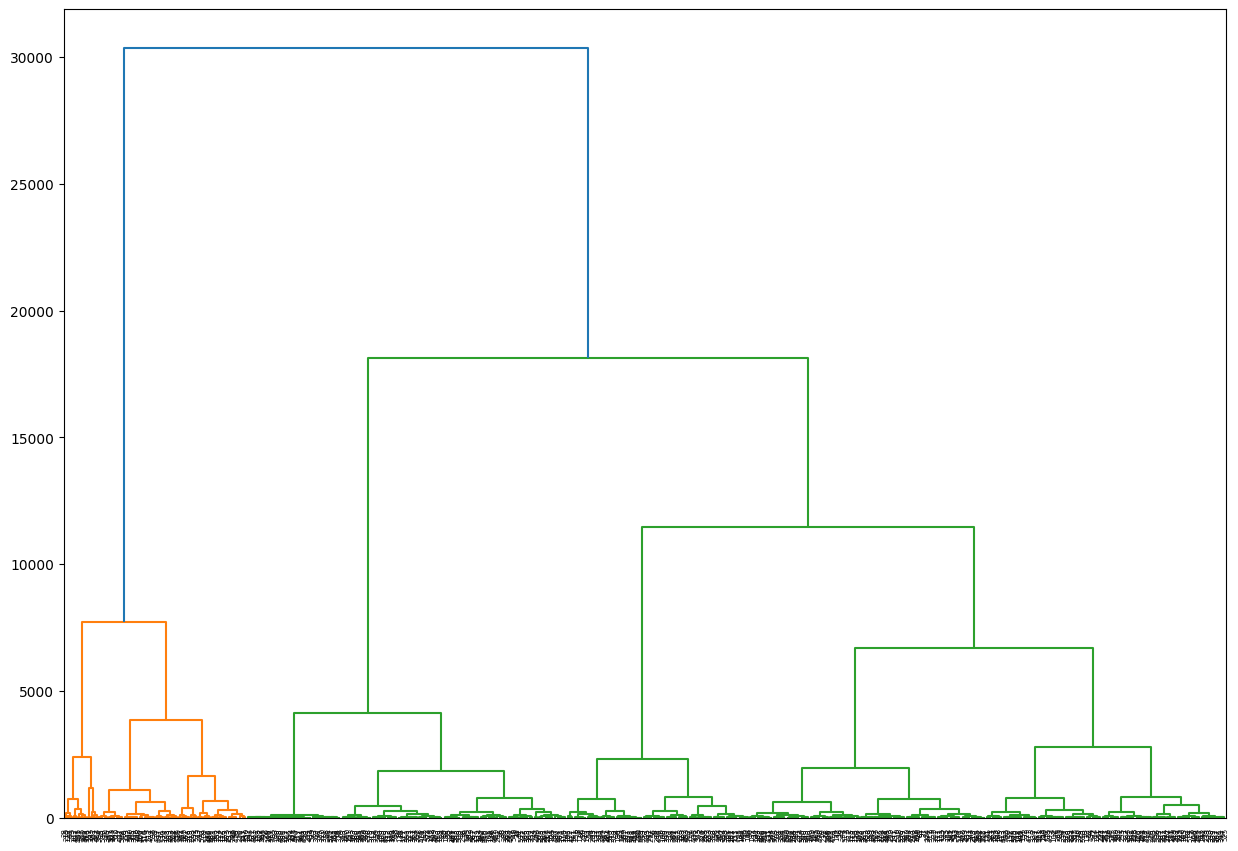

In [ ]:
linkage_data = linkage(data_cluster, method='ward', metric='euclidean')
fig = plt.figure(figsize=(15, 10.5))
dendrogram(linkage_data)
plt.show()

Elbow Rule

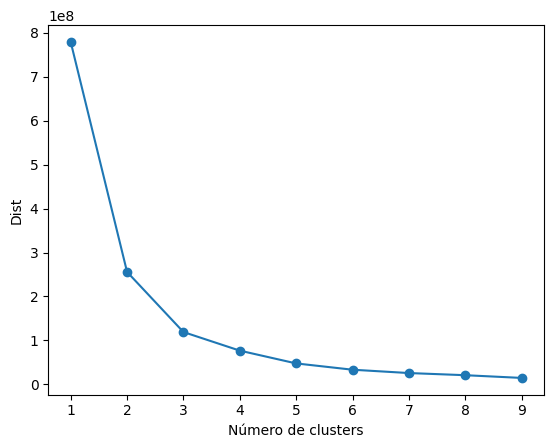

In [ ]:
dist=[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, n_init='auto')
  km.fit(data_cluster)
  """
  km.inertia_ corresponde a la suma de las distancias al cuadrado de
  las muestras a su centroide mas ceraano, ponderada por los pesos
  de la muestra, es decir, a la variabilidad promedio.
  """
  dist.append(km.inertia_)

plt.plot(range(1, 10), dist, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Dist')
plt.show()

K-MEANS

In [ ]:
kmeans = KMeans(n_clusters = 3, n_init = 'auto')
labels_kmeans = kmeans.fit_predict(data_cluster)

kmeans_dataframe = pd.DataFrame(data_cluster.index, index = data_cluster.index, columns = ['Cluster'])
kmeans_dataframe['Cluster'] = labels_kmeans
kmeans_dataframe.head()

,Cluster
0,1
1,0
2,0
3,0
4,0


TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_data = tsne.fit_transform(data_cluster)

In [ ]:
labels = ['C1', 'C2']
#Metemos las coordenadas obtenidas por el T-SNE a un dataframe
tsne_dataframe = pd.DataFrame(tsne_data, columns = labels)

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = labels_kmeans, title = "T-SNE - KMEANS ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:

fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = duracion, title = "T-SNE - Duracion ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:

fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = distance, title = "T-SNE - Distance ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

Quitamos la distancia

In [ ]:
data_cluster = data_cluster.drop(['Distancia'], axis=1)

data_cluster.head()

,Edad,Genero,Dia,Hora,Zona de origen,Zona de destino
0,36,0,1,18,1,1
1,28,0,5,19,1,1
2,24,0,2,11,2,2
3,53,1,4,19,1,1
4,26,0,7,21,2,2


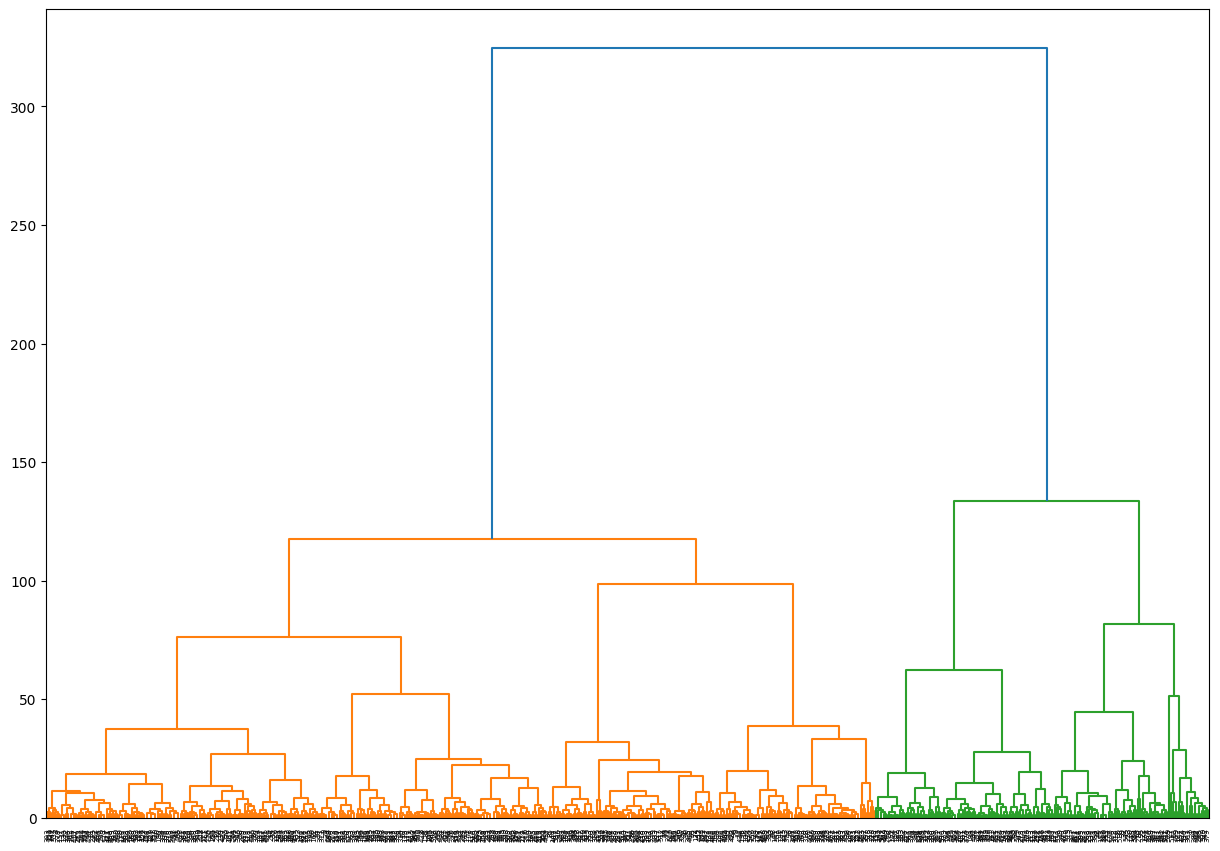

In [ ]:
linkage_data = linkage(data_cluster, method='ward', metric='euclidean')
fig = plt.figure(figsize=(15, 10.5))
dendrogram(linkage_data)
plt.show()

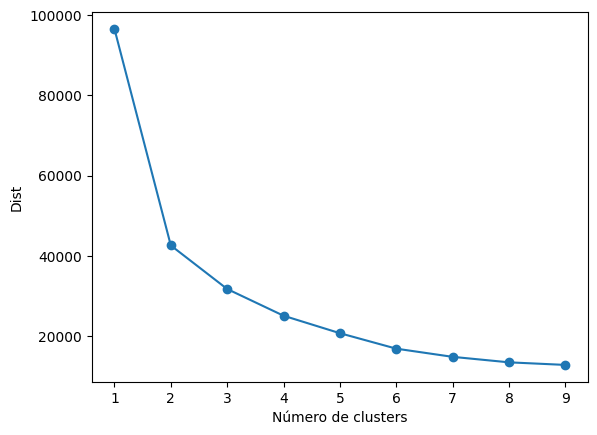

In [ ]:
dist=[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, n_init='auto')
  km.fit(data_cluster)
  """
  km.inertia_ corresponde a la suma de las distancias al cuadrado de
  las muestras a su centroide mas ceraano, ponderada por los pesos
  de la muestra, es decir, a la variabilidad promedio.
  """
  dist.append(km.inertia_)

plt.plot(range(1, 10), dist, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Dist')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, n_init = 'auto')
labels_kmeans = kmeans.fit_predict(data_cluster)

kmeans_dataframe = pd.DataFrame(data_cluster.index, index = data_cluster.index, columns = ['Cluster'])
kmeans_dataframe['Cluster'] = labels_kmeans
kmeans_dataframe.head()

,Cluster
0,0
1,0
2,0
3,1
4,0


In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_data = tsne.fit_transform(data_cluster)

In [ ]:
labels = ['C1', 'C2']
#Metemos las coordenadas obtenidas por el T-SNE a un dataframe
tsne_dataframe = pd.DataFrame(tsne_data, columns = labels)

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = labels_kmeans, title = "T-SNE - KMEANS ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:

fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = duracion, title = "T-SNE - Duracion ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

## Predicción

### Árboles de decisión

In [ ]:
data1 = totalData
data1 = data1.drop(['Duracion'], axis=1)
data1 = data1.drop(['Intervalo de duracion'], axis=1)
data1 = data1.drop(['Origen ID'], axis=1)
data1 = data1.drop(['Destino ID'], axis=1)


data1.head()

,Edad,Genero,Dia,Hora,Distancia,Zona de origen,Zona de destino
0,36,0,1,18,791.957123,1,1
1,28,0,5,19,1802.525253,1,1
2,24,0,2,11,1997.349364,2,2
3,53,1,4,19,1430.854395,1,1
4,26,0,7,21,1316.957751,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data1, duracionInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Árbol de decisión')

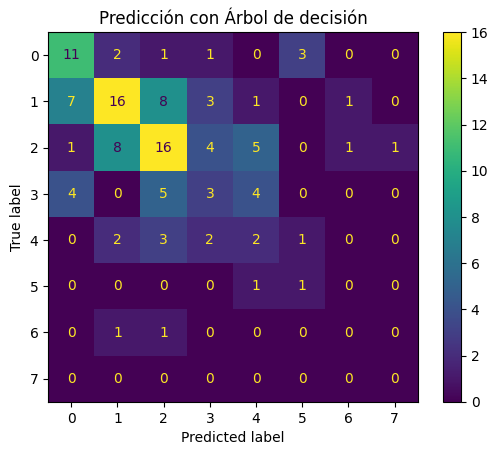

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Árbol de decisión")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.61      0.54        18
           2       0.55      0.44      0.49        36
           3       0.47      0.44      0.46        36
           4       0.23      0.19      0.21        16
           5       0.15      0.20      0.17        10
           6       0.20      0.50      0.29         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0

    accuracy                           0.41       120
   macro avg       0.26      0.30      0.27       120
weighted avg       0.43      0.41      0.41       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



**¿La distancia está haciendo todo el trabajo al tener mucho que ver con la duración?**

In [ ]:
data1 = data1.drop(['Distancia'], axis=1)

data1.head()

,Edad,Genero,Dia,Hora,Zona de origen,Zona de destino
0,36,0,1,18,1,1
1,28,0,5,19,1,1
2,24,0,2,11,2,2
3,53,1,4,19,1,1
4,26,0,7,21,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data1, duracionInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Árbol de decisión')

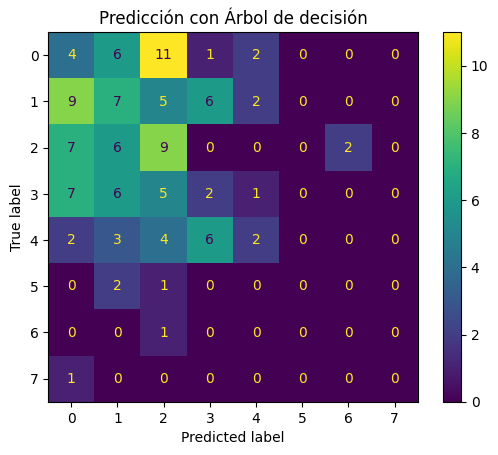

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Árbol de decisión")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.13      0.17      0.15        24
           2       0.23      0.24      0.24        29
           3       0.25      0.38      0.30        24
           4       0.13      0.10      0.11        21
           5       0.29      0.12      0.17        17
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.20       120
   macro avg       0.13      0.12      0.12       120
weighted avg       0.20      0.20      0.19       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Clasificador Bayesiano Óptimo

In [ ]:
data1 = totalData
data1 = data1.drop(['Duracion'], axis=1)
data1 = data1.drop(['Intervalo de duracion'], axis=1)
data1 = data1.drop(['Origen ID'], axis=1)
data1 = data1.drop(['Destino ID'], axis=1)
data1.head()

,Edad,Genero,Dia,Hora,Distancia,Zona de origen,Zona de destino
0,36,0,1,18,791.957123,1,1
1,28,0,5,19,1802.525253,1,1
2,24,0,2,11,1997.349364,2,2
3,53,1,4,19,1430.854395,1,1
4,26,0,7,21,1316.957751,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data1, duracionInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = GaussianNB()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Clasificador Bayesiano Óptimo')

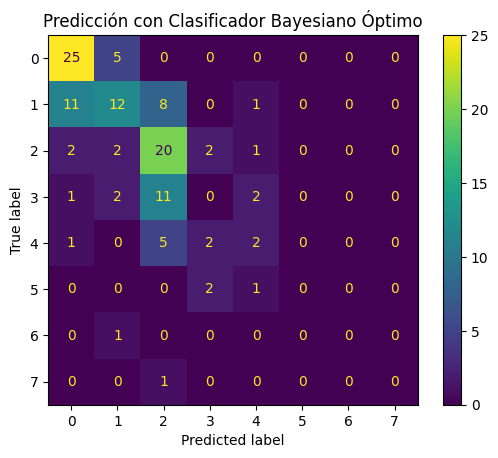

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Clasificador Bayesiano Óptimo")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.83      0.71        30
           2       0.55      0.38      0.44        32
           3       0.44      0.74      0.56        27
           4       0.00      0.00      0.00        16
           5       0.29      0.20      0.24        10
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.49       120
   macro avg       0.24      0.27      0.24       120
weighted avg       0.43      0.49      0.44       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**¿La distancia está haciendo todo el trabajo al tener mucho que ver con la duración?**

In [ ]:
data1 = data1.drop(['Distancia'], axis=1)

data1.head()

,Edad,Genero,Dia,Hora,Zona de origen,Zona de destino
0,36,0,1,18,1,1
1,28,0,5,19,1,1
2,24,0,2,11,2,2
3,53,1,4,19,1,1
4,26,0,7,21,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data1, duracionInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = GaussianNB()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Clasificador Bayesiano Óptimo')

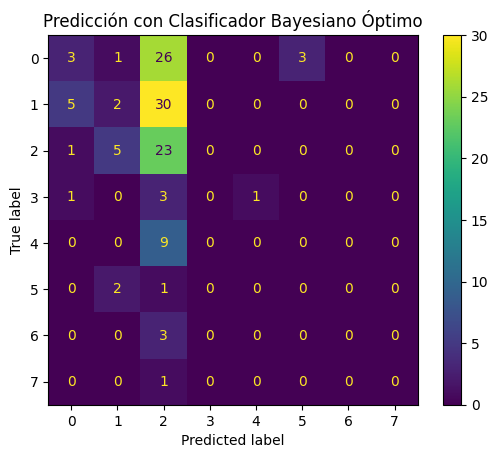

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Clasificador Bayesiano Óptimo")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.30      0.09      0.14        33
           2       0.20      0.05      0.09        37
           3       0.24      0.79      0.37        29
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1

    accuracy                           0.23       120
   macro avg       0.09      0.12      0.07       120
weighted avg       0.20      0.23      0.15       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Variable de interés: Zona de Origen

In [ ]:
datavis2 = totalData
datavis2 = datavis2.drop(['Intervalo de duracion'], axis=1)
datavis2 = datavis2.drop(['Zona de origen'], axis=1)
datavis2 = datavis2.drop(['Zona de destino'], axis=1)
datavis2 = datavis2.drop(['Origen ID'], axis=1)
datavis2 = datavis2.drop(['Destino ID'], axis=1)
datavis2 = datavis2.drop(['Genero'], axis=1)

datavis2.head()

,Edad,Dia,Hora,Duracion,Distancia
0,36,1,18,6.916667,791.957123
1,28,5,19,11.383333,1802.525253
2,24,2,11,12.333333,1997.349364
3,53,4,19,8.866667,1430.854395
4,26,7,21,7.533333,1316.957751


In [ ]:
sDatavis2 = StandardScaler().fit_transform(datavis2)

In [ ]:
pca = PCA() #Creamos el objeto PCA
pca.fit(sDatavis2) #Con esta funcion calculamos los loading scores y la variacion asociada a cada CP

pca_data = pca.transform(sDatavis2) #Coordenadas de las proyecciones de los datos respecto a los Principal Components

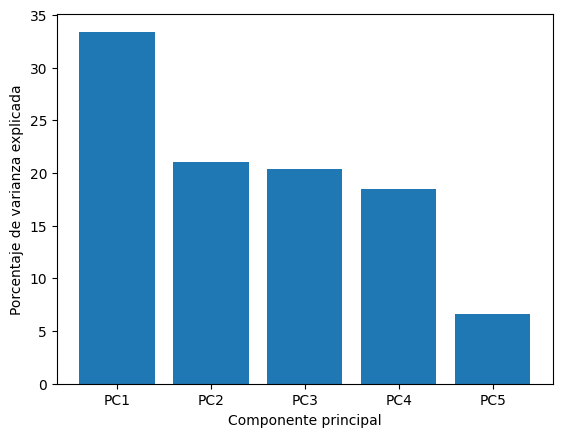

In [ ]:
#Calculamos el porcentaje de varianza asociado a cada componente (lo redondeamos)
var_explained = np.round(pca.explained_variance_ratio_*100, decimals = 1)

#Creamos las etiquetas de la grafica, una para cada CP (PC en ingles)
labels = ['PC' + str(x) for x in range(1, len(var_explained) + 1)] #PC1, PC2, PC3, ...

#Creamos una barplot con estos datos
plt.bar(x = range(1, len(var_explained) + 1), height = var_explained, tick_label = labels)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.show()

In [ ]:
pca_dataframe = pd.DataFrame(pca_data, columns = labels)
pca_dataframe['Zona Origen'] =  zonaOrigen

pca_dataframe.head()

,PC1,PC2,PC3,PC4,PC5,Zona Origen
0,-0.851597,-1.465336,0.197993,0.227242,0.078262,1
1,0.374975,-0.073655,-1.071736,-0.755622,-0.173890,1
2,0.369475,-0.082422,-0.322151,1.388341,0.023490,2
3,-0.263057,-0.431184,0.970654,-1.477197,-0.334433,1
4,-0.198400,0.370925,-1.776167,-1.599286,-0.325153,2


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis2.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Zona Origen", title = "PCA - Origen ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


## Agrupamiento

In [ ]:
data_cluster2 = totalData
data_cluster2 = data_cluster2.drop(['Origen ID'], axis=1)
data_cluster2 = data_cluster2.drop(['Destino ID'], axis=1)
data_cluster2 = data_cluster2.drop(['Zona de origen'], axis=1)

data_cluster2.head()

,Edad,Genero,Dia,Hora,Duracion,Distancia,Intervalo de duracion,Zona de destino
0,36,0,1,18,6.916667,791.957123,2,1
1,28,0,5,19,11.383333,1802.525253,3,1
2,24,0,2,11,12.333333,1997.349364,3,2
3,53,1,4,19,8.866667,1430.854395,2,1
4,26,0,7,21,7.533333,1316.957751,2,2


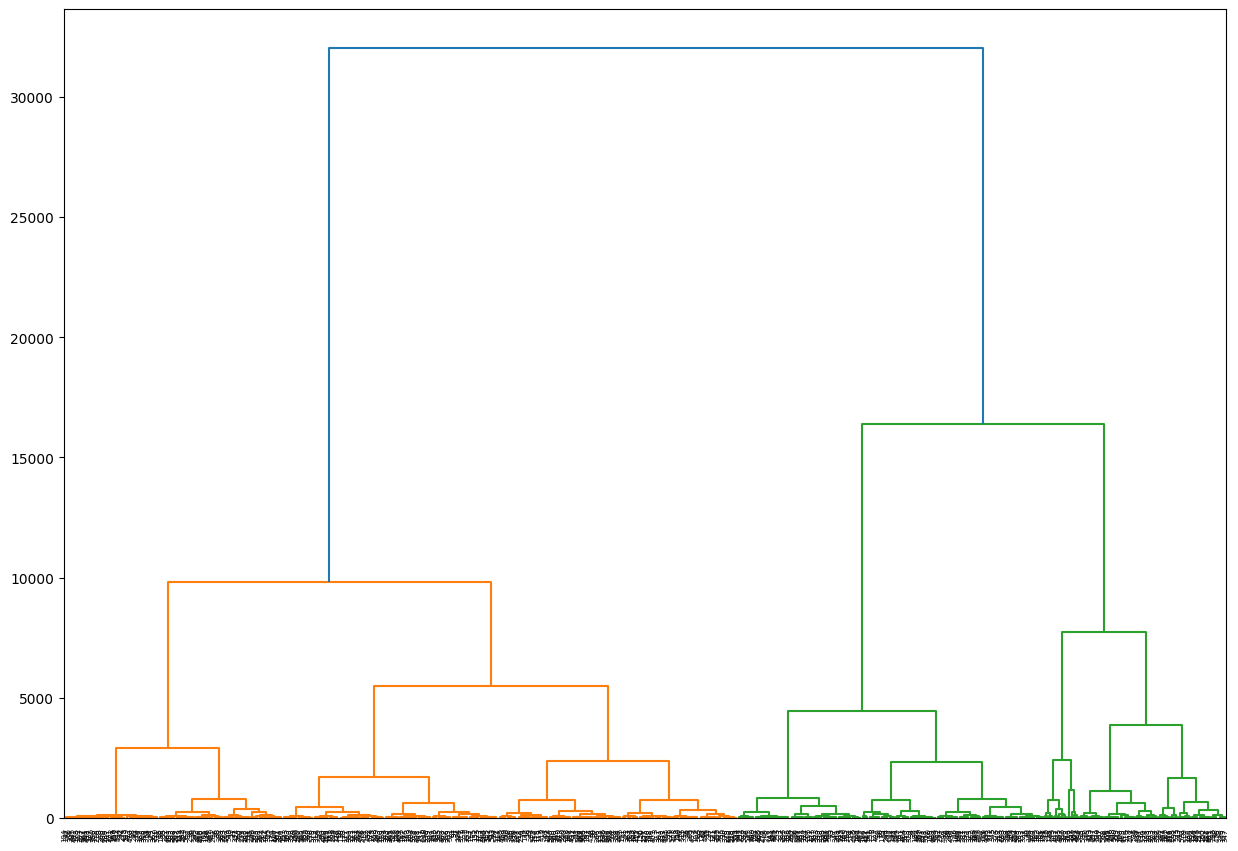

In [ ]:
linkage_data = linkage(data_cluster2, method='ward', metric='euclidean')
fig = plt.figure(figsize=(15, 10.5))
dendrogram(linkage_data)
plt.show()

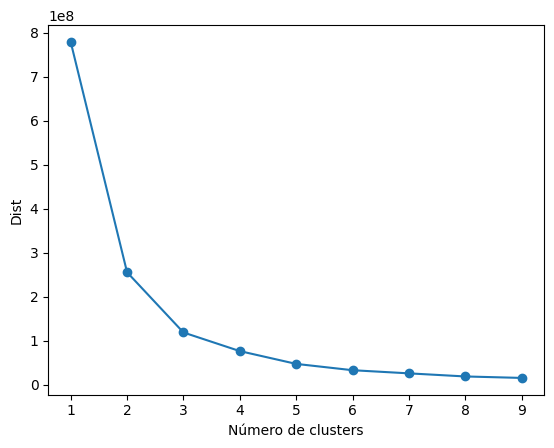

In [ ]:
dist=[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, n_init='auto')
  km.fit(data_cluster2)
  """
  km.inertia_ corresponde a la suma de las distancias al cuadrado de
  las muestras a su centroide mas ceraano, ponderada por los pesos
  de la muestra, es decir, a la variabilidad promedio.
  """
  dist.append(km.inertia_)

plt.plot(range(1, 10), dist, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Dist')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, n_init = 'auto')
labels_kmeans = kmeans.fit_predict(data_cluster2)

kmeans_dataframe = pd.DataFrame(data_cluster2.index, index = data_cluster2.index, columns = ['Cluster'])
kmeans_dataframe['Cluster'] = labels_kmeans
kmeans_dataframe.head()

,Cluster
0,0
1,2
2,2
3,2
4,2


In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_data = tsne.fit_transform(data_cluster2)

In [ ]:
labels = ['C1', 'C2']
#Metemos las coordenadas obtenidas por el T-SNE a un dataframe
tsne_dataframe = pd.DataFrame(tsne_data, columns = labels)

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = labels_kmeans, title = "T-SNE - KMEANS ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = zonaOrigen, title = "T-SNE - Zona de Origen ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

## Predicción

### Árboles de decisión

In [ ]:
data2 = totalData
data2 = data2.drop(['Zona de origen'], axis=1)
data2 = data2.drop(['Origen ID'], axis=1)
data2 = data2.drop(['Destino ID'], axis=1)

data2.head()

,Edad,Genero,Dia,Hora,Duracion,Distancia,Intervalo de duracion,Zona de destino
0,36,0,1,18,6.916667,791.957123,2,1
1,28,0,5,19,11.383333,1802.525253,3,1
2,24,0,2,11,12.333333,1997.349364,3,2
3,53,1,4,19,8.866667,1430.854395,2,1
4,26,0,7,21,7.533333,1316.957751,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2, zonaOrigen, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Árbol de Decisión')

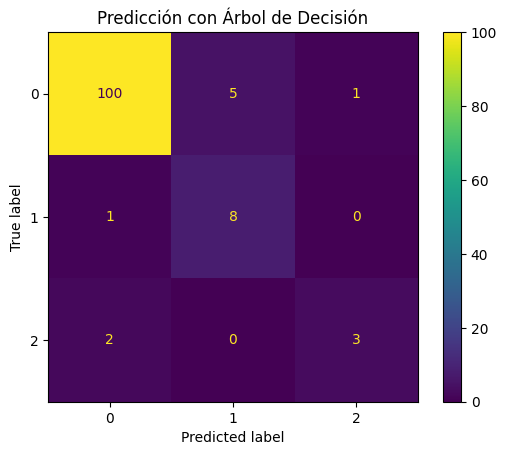

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Árbol de Decisión")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.94      0.96       106
           2       0.62      0.89      0.73         9
           3       0.75      0.60      0.67         5

    accuracy                           0.93       120
   macro avg       0.78      0.81      0.78       120
weighted avg       0.94      0.93      0.93       120



**Predice bien ya que la mayoría caen en la Zona 1**


### Clasificador Bayesiano Óptimo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2, zonaOrigen, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = GaussianNB()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Clasificador Bayesiano Óptimo')

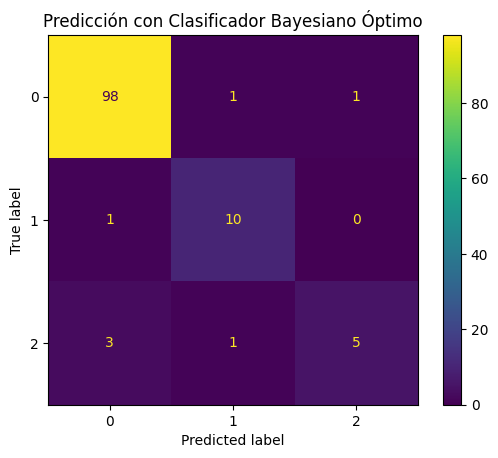

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Clasificador Bayesiano Óptimo")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97       100
           2       0.83      0.91      0.87        11
           3       0.83      0.56      0.67         9

    accuracy                           0.94       120
   macro avg       0.88      0.81      0.84       120
weighted avg       0.94      0.94      0.94       120



# Variable de interés: Zona de Destino

## Visualización

In [ ]:
datavis3 = totalData
datavis3 = datavis3.drop(['Intervalo de duracion'], axis=1)
datavis3 = datavis3.drop(['Zona de origen'], axis=1)
datavis3 = datavis3.drop(['Zona de destino'], axis=1)
datavis3 = datavis3.drop(['Origen ID'], axis=1)
datavis3 = datavis3.drop(['Destino ID'], axis=1)
datavis3 = datavis3.drop(['Genero'], axis=1)

datavis3.head()

,Edad,Dia,Hora,Duracion,Distancia
0,36,1,18,6.916667,791.957123
1,28,5,19,11.383333,1802.525253
2,24,2,11,12.333333,1997.349364
3,53,4,19,8.866667,1430.854395
4,26,7,21,7.533333,1316.957751


In [ ]:
sDatavis3 = StandardScaler().fit_transform(datavis3)

In [ ]:
pca = PCA() #Creamos el objeto PCA
pca.fit(sDatavis3) #Con esta funcion calculamos los loading scores y la variacion asociada a cada CP

pca_data = pca.transform(sDatavis3) #Coordenadas de las proyecciones de los datos respecto a los Principal Components

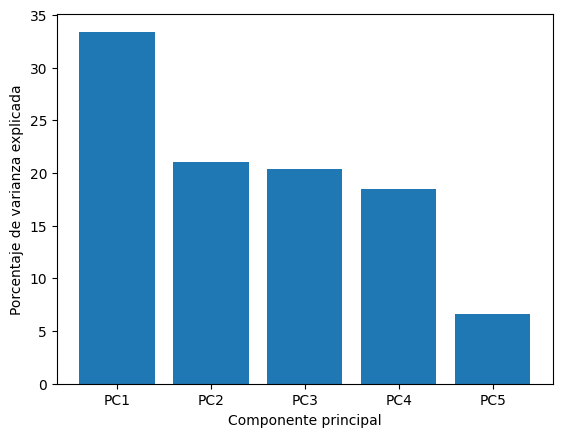

In [ ]:
#Calculamos el porcentaje de varianza asociado a cada componente (lo redondeamos)
var_explained = np.round(pca.explained_variance_ratio_*100, decimals = 1)

#Creamos las etiquetas de la grafica, una para cada CP (PC en ingles)
labels = ['PC' + str(x) for x in range(1, len(var_explained) + 1)] #PC1, PC2, PC3, ...

#Creamos una barplot con estos datos
plt.bar(x = range(1, len(var_explained) + 1), height = var_explained, tick_label = labels)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.show()

In [ ]:
pca_dataframe = pd.DataFrame(pca_data, columns = labels)
pca_dataframe['Zona Destino'] =  zonaDestino

pca_dataframe.head()

,PC1,PC2,PC3,PC4,PC5,Zona Destino
0,-0.851597,-1.465336,0.197993,0.227242,0.078262,1
1,0.374975,-0.073655,-1.071736,-0.755622,-0.173890,1
2,0.369475,-0.082422,-0.322151,1.388341,0.023490,2
3,-0.263057,-0.431184,0.970654,-1.477197,-0.334433,1
4,-0.198400,0.370925,-1.776167,-1.599286,-0.325153,2


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis3.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Zona Destino", title = "PCA - Destino ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


Vemos que los puntos correspondientes a la Zona 2 se encuentran la mayoría concentrados en un cumulo en sentido opuesto a las flechas de Distancia y de Duración. Esto quizás nos podría indicar que la Zona 2 (ZAPOPAN CENTRO) es más pequeña que las otras y sus estaciones no se encuentran tan dispersas entre sí.

## Agrupamiento

In [ ]:
data_cluster3 = totalData
data_cluster3 = data_cluster3.drop(['Origen ID'], axis=1)
data_cluster3 = data_cluster3.drop(['Destino ID'], axis=1)
data_cluster3 = data_cluster3.drop(['Zona de destino'], axis=1)

data_cluster3.head()

,Edad,Genero,Dia,Hora,Duracion,Distancia,Intervalo de duracion,Zona de origen
0,36,0,1,18,6.916667,791.957123,2,1
1,28,0,5,19,11.383333,1802.525253,3,1
2,24,0,2,11,12.333333,1997.349364,3,2
3,53,1,4,19,8.866667,1430.854395,2,1
4,26,0,7,21,7.533333,1316.957751,2,2


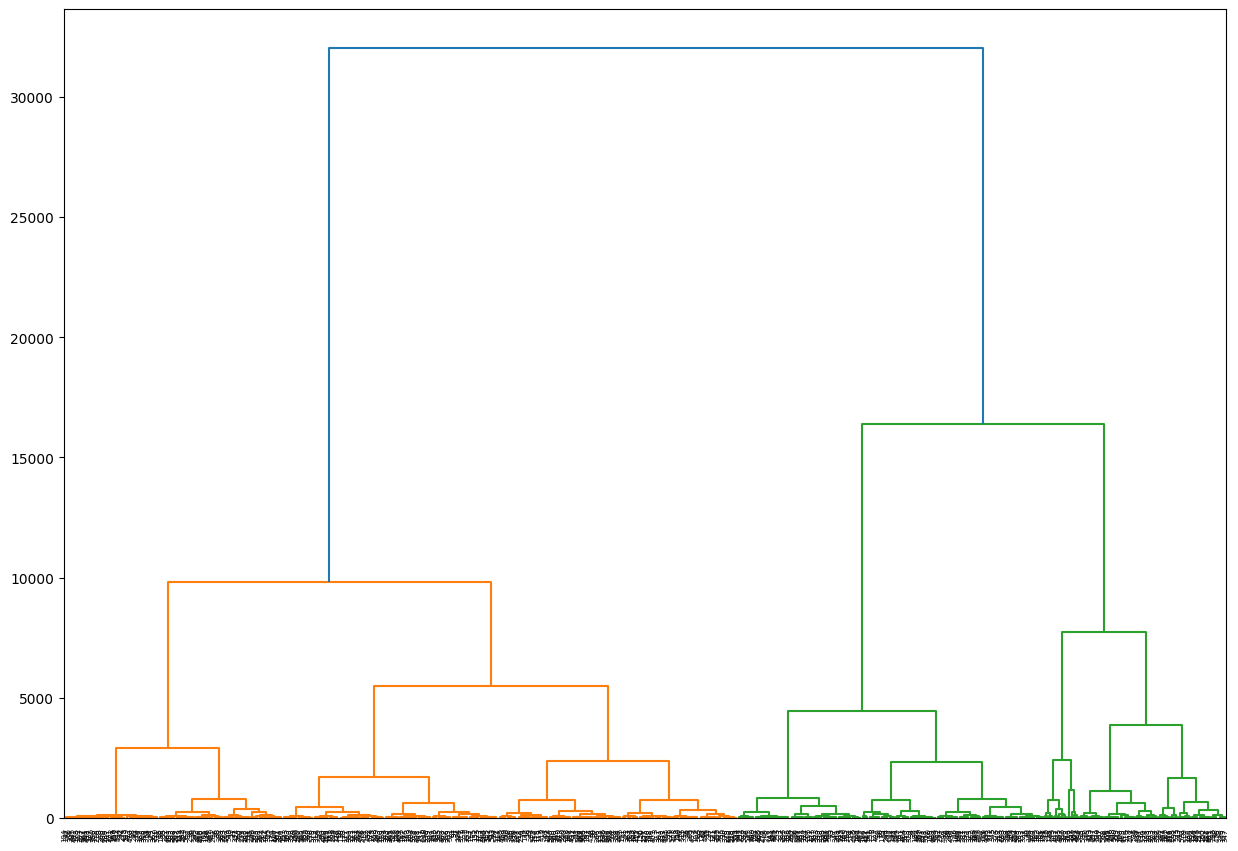

In [ ]:
linkage_data = linkage(data_cluster3, method='ward', metric='euclidean')
fig = plt.figure(figsize=(15, 10.5))
dendrogram(linkage_data)
plt.show()

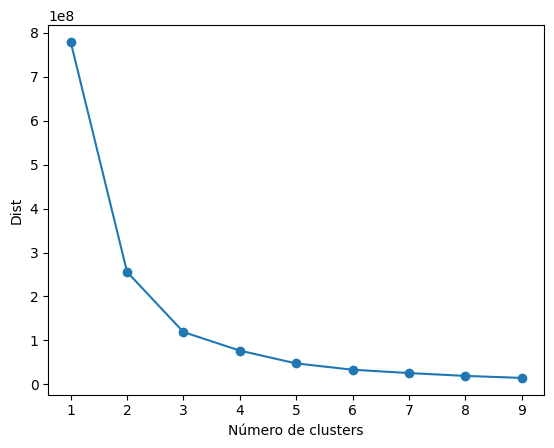

In [ ]:
dist=[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, n_init='auto')
  km.fit(data_cluster3)
  """
  km.inertia_ corresponde a la suma de las distancias al cuadrado de
  las muestras a su centroide mas ceraano, ponderada por los pesos
  de la muestra, es decir, a la variabilidad promedio.
  """
  dist.append(km.inertia_)

plt.plot(range(1, 10), dist, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Dist')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, n_init = 'auto')
labels_kmeans = kmeans.fit_predict(data_cluster3)

kmeans_dataframe = pd.DataFrame(data_cluster3.index, index = data_cluster3.index, columns = ['Cluster'])
kmeans_dataframe['Cluster'] = labels_kmeans
kmeans_dataframe.head()

,Cluster
0,1
1,2
2,2
3,2
4,2


In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_data = tsne.fit_transform(data_cluster3)

labels = ['C1', 'C2']
#Metemos las coordenadas obtenidas por el T-SNE a un dataframe
tsne_dataframe = pd.DataFrame(tsne_data, columns = labels)



In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = labels_kmeans, title = "T-SNE - KMEANS ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = zonaDestino, title = "T-SNE - Zona de Destino ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

## Predicción

### Árboles de decisión

In [ ]:
data3 = totalData
data3 = data3.drop(['Zona de destino'], axis=1)
data3 = data3.drop(['Destino ID'], axis=1)
data3 = data3.drop(['Origen ID'], axis=1)
data3 = data3.drop(['Intervalo de duracion'], axis=1)
data3.head()

,Edad,Genero,Dia,Hora,Duracion,Distancia,Zona de origen
0,36,0,1,18,6.916667,791.957123,1
1,28,0,5,19,11.383333,1802.525253,1
2,24,0,2,11,12.333333,1997.349364,2
3,53,1,4,19,8.866667,1430.854395,1
4,26,0,7,21,7.533333,1316.957751,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data3, zonaDestino, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Árbol de Decisión')

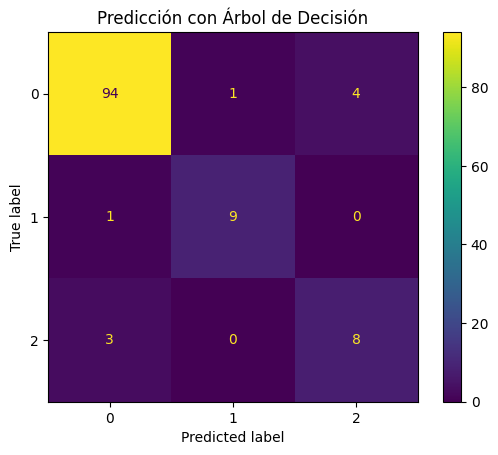

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Árbol de Decisión")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.95      0.95        99
           2       0.90      0.90      0.90        10
           3       0.67      0.73      0.70        11

    accuracy                           0.93       120
   macro avg       0.84      0.86      0.85       120
weighted avg       0.93      0.93      0.93       120



### Clasificador Bayesiano Óptimo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data3, zonaDestino, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = GaussianNB()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Clasificador Bayesiano Óptimo')

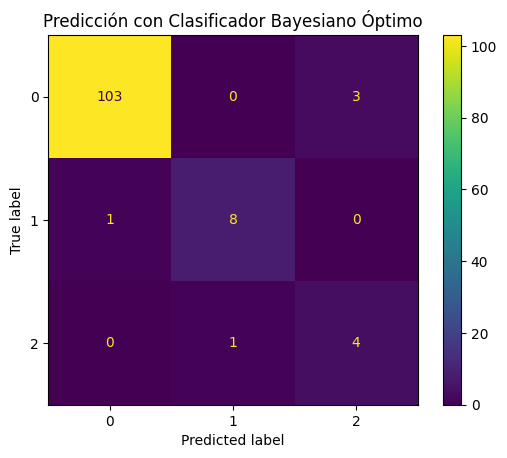

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Clasificador Bayesiano Óptimo")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       106
           2       0.89      0.89      0.89         9
           3       0.57      0.80      0.67         5

    accuracy                           0.96       120
   macro avg       0.82      0.89      0.85       120
weighted avg       0.97      0.96      0.96       120



# Variable de interes: Hora del día

## Division de horas del dia en intervalos

In [ ]:
hourInterval = []

for i in range(len(hour)):
  if hour[i] >= 0 and hour[i] < 6:
    #Madrugada
    hourInterval.append(0)
  elif hour[i] >= 6 and hour[i] < 12:
    #Mañana
    hourInterval.append(1)
  elif hour[i] >= 12 and hour[i] < 18:
    #Tarde
    hourInterval.append(2)
  else:
    #Noche
    hourInterval.append(3)


## Visualización

In [ ]:
datavis4 = totalData
datavis4 = datavis4.drop(['Intervalo de duracion'], axis=1)
datavis4 = datavis4.drop(['Zona de origen'], axis=1)
datavis4 = datavis4.drop(['Zona de destino'], axis=1)
datavis4 = datavis4.drop(['Origen ID'], axis=1)
datavis4 = datavis4.drop(['Destino ID'], axis=1)
datavis4 = datavis4.drop(['Genero'], axis=1)
datavis4 = datavis4.drop(['Hora'], axis=1)

datavis4.head()

,Edad,Dia,Duracion,Distancia
0,36,1,6.916667,791.957123
1,28,5,11.383333,1802.525253
2,24,2,12.333333,1997.349364
3,53,4,8.866667,1430.854395
4,26,7,7.533333,1316.957751


In [ ]:
sDatavis4 = StandardScaler().fit_transform(datavis4)

In [ ]:
pca = PCA() #Creamos el objeto PCA
pca.fit(sDatavis4) #Con esta funcion calculamos los loading scores y la variacion asociada a cada CP

pca_data = pca.transform(sDatavis4) #Coordenadas de las proyecciones de los datos respecto a los Principal Components

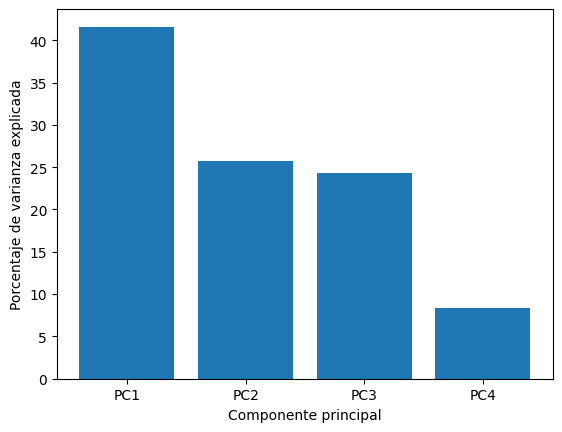

In [ ]:
#Calculamos el porcentaje de varianza asociado a cada componente (lo redondeamos)
var_explained = np.round(pca.explained_variance_ratio_*100, decimals = 1)

#Creamos las etiquetas de la grafica, una para cada CP (PC en ingles)
labels = ['PC' + str(x) for x in range(1, len(var_explained) + 1)] #PC1, PC2, PC3, ...

#Creamos una barplot con estos datos
plt.bar(x = range(1, len(var_explained) + 1), height = var_explained, tick_label = labels)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.show()

In [ ]:
pca_dataframe = pd.DataFrame(pca_data, columns = labels)
pca_dataframe['Tiempo del dia'] =  hourInterval

pca_dataframe.head()

,PC1,PC2,PC3,PC4,Tiempo del dia
0,-0.939605,0.897316,-0.863955,0.126175,3
1,0.286417,-0.966792,0.141128,-0.107840,3
2,0.431376,-0.113808,-1.229274,-0.033768,1
3,-0.349413,0.918145,1.268786,-0.262229,3
4,-0.323317,-1.873262,0.765679,-0.223674,3


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

features = datavis4.columns


fig = px.scatter(pca_dataframe, x = "PC1", y = "PC2", color = "Tiempo del dia", title = "PCA - Hour ColorMap", width = 1500/1.25, height = 1050/1.25)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


## Agrupamiento

In [ ]:
data_cluster4 = totalData
data_cluster4 = data_cluster4.drop(['Origen ID'], axis=1)
data_cluster4 = data_cluster4.drop(['Destino ID'], axis=1)
data_cluster4 = data_cluster4.drop(['Hora'], axis=1)
data_cluster4 = data_cluster4.drop(['Intervalo de duracion'], axis=1)

data_cluster4.head()

,Edad,Genero,Dia,Duracion,Distancia,Zona de origen,Zona de destino
0,36,0,1,6.916667,791.957123,1,1
1,28,0,5,11.383333,1802.525253,1,1
2,24,0,2,12.333333,1997.349364,2,2
3,53,1,4,8.866667,1430.854395,1,1
4,26,0,7,7.533333,1316.957751,2,2


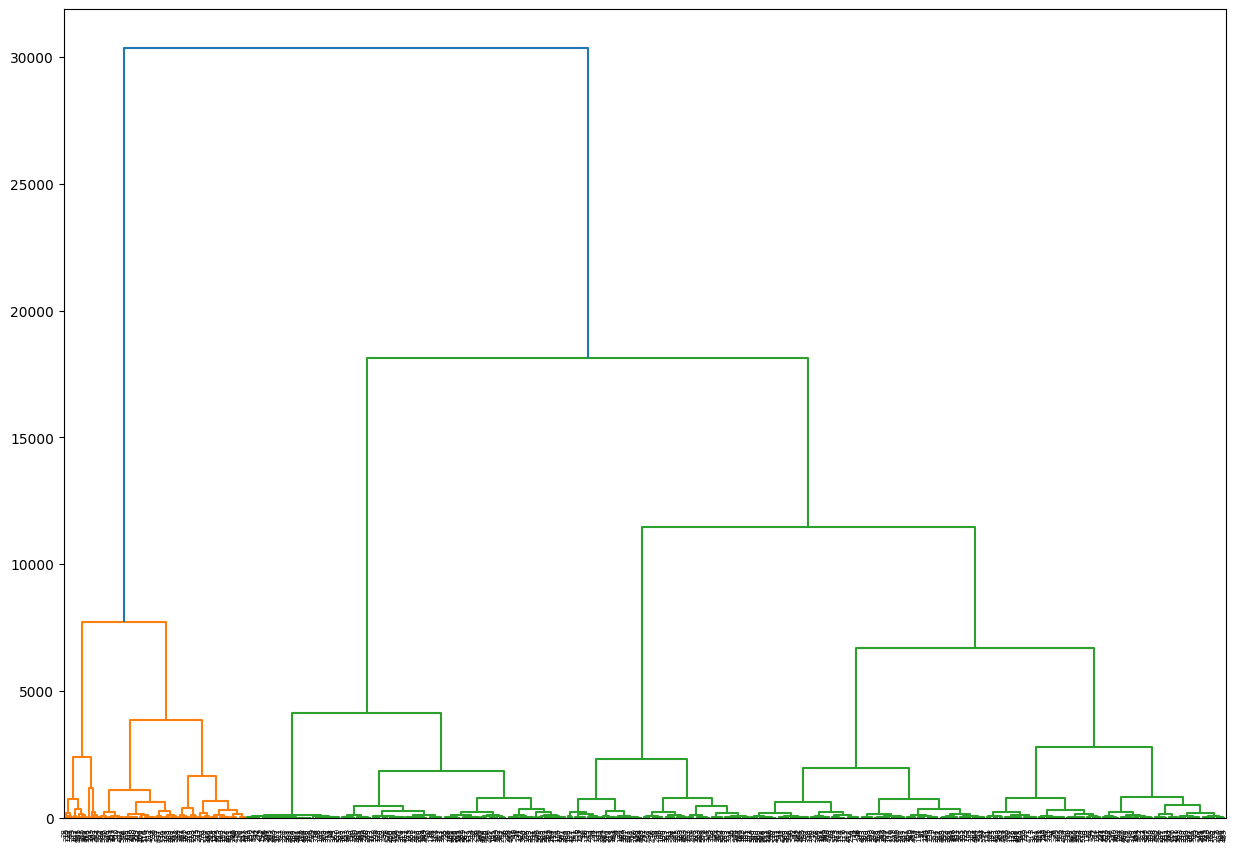

In [ ]:
linkage_data = linkage(data_cluster4, method='ward', metric='euclidean')
fig = plt.figure(figsize=(15, 10.5))
dendrogram(linkage_data)
plt.show()

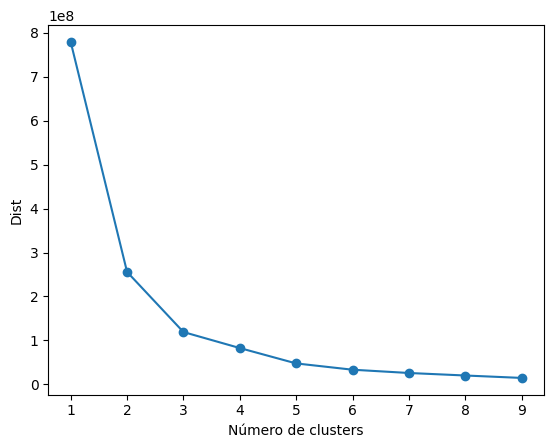

In [ ]:
dist=[]
for i in range(1, 10):
  km = KMeans(n_clusters = i, n_init='auto')
  km.fit(data_cluster4)
  """
  km.inertia_ corresponde a la suma de las distancias al cuadrado de
  las muestras a su centroide mas ceraano, ponderada por los pesos
  de la muestra, es decir, a la variabilidad promedio.
  """
  dist.append(km.inertia_)

plt.plot(range(1, 10), dist, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Dist')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, n_init = 'auto')
labels_kmeans = kmeans.fit_predict(data_cluster4)

kmeans_dataframe = pd.DataFrame(data_cluster4.index, index = data_cluster4.index, columns = ['Cluster'])
kmeans_dataframe['Cluster'] = labels_kmeans
kmeans_dataframe.head()

,Cluster
0,1
1,2
2,2
3,2
4,2


In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_data = tsne.fit_transform(data_cluster4)

labels = ['C1', 'C2']
#Metemos las coordenadas obtenidas por el T-SNE a un dataframe
tsne_dataframe = pd.DataFrame(tsne_data, columns = labels)



In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = labels_kmeans, title = "T-SNE - KMEANS ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = hour, title = "T-SNE - Hora ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

In [ ]:
fig = px.scatter(tsne_dataframe, x = "C1", y = "C2", color = hourInterval, title = "T-SNE - Intervalo de horas ColorMap", width = 1500/1.25, height = 1050/1.25)
fig.show()

## Predicción

### Árboles de decisión

In [ ]:
data4 = totalData
data4 = data4.drop(['Hora'], axis=1)
data4 = data4.drop(['Origen ID'], axis=1)
data4 = data4.drop(['Destino ID'], axis=1)
data4 = data4.drop(['Intervalo de duracion'], axis=1)
data4.head()

,Edad,Genero,Dia,Duracion,Distancia,Zona de origen,Zona de destino
0,36,0,1,6.916667,791.957123,1,1
1,28,0,5,11.383333,1802.525253,1,1
2,24,0,2,12.333333,1997.349364,2,2
3,53,1,4,8.866667,1430.854395,1,1
4,26,0,7,7.533333,1316.957751,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data4, hourInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Árbol de Decisión')

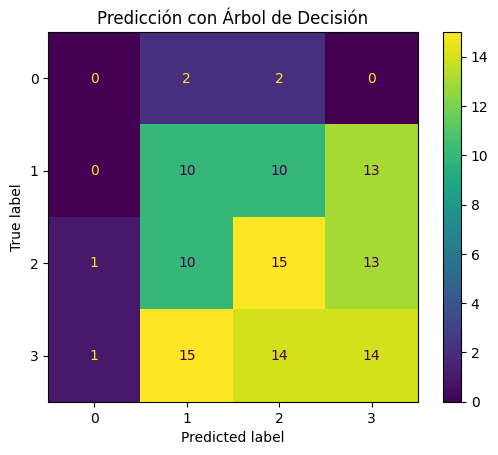

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Árbol de Decisión")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.27      0.30      0.29        33
           2       0.37      0.38      0.37        39
           3       0.35      0.32      0.33        44

    accuracy                           0.33       120
   macro avg       0.25      0.25      0.25       120
weighted avg       0.32      0.33      0.32       120



### Clasificador Bayesiano Óptimo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data4, hourInterval, test_size=0.20)
X_trainS = StandardScaler().fit_transform(X_train)
X_testS = StandardScaler().fit_transform(X_test)

clf = GaussianNB()
clf.fit(X_trainS, y_train)

y_pred = clf.predict(X_testS)

Text(0.5, 1.0, 'Predicción con Clasificador Bayesiano Óptimo')

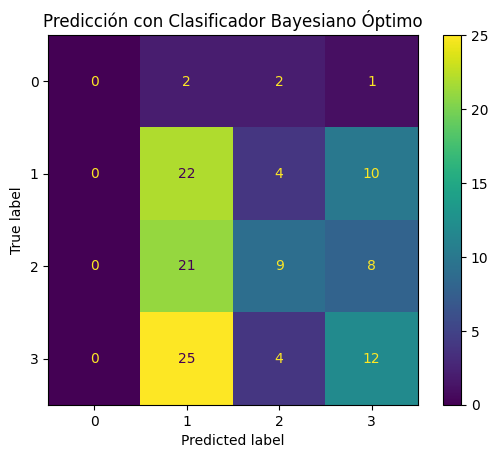

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_testS))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Predicción con Clasificador Bayesiano Óptimo")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.31      0.61      0.42        36
           2       0.47      0.24      0.32        38
           3       0.39      0.29      0.33        41

    accuracy                           0.36       120
   macro avg       0.29      0.29      0.27       120
weighted avg       0.38      0.36      0.34       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

